# Supermodelling

### Set up the complex system

In [1]:
from scipy.integrate import odeint
import numpy as np


def lotka_volterra(vars, t, *params):
    alpha, beta, delta, gamma, epsilon, eta, zeta = params
    x, y, z = vars
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y - epsilon * y * z
    dzdt = eta * y * z - zeta * z
    return [dxdt, dydt, dzdt]


# model to return values of the system at samples_t points in time for given params
def lotka_volterra_sampler(
    samples_t,
    *params,
):

    alpha, beta, delta, gamma, epsilon, eta, zeta, x0, y0, z0 = params

    initial_values = [x0, y0, z0]

    response_y = np.zeros((len(samples_t), len(initial_values)))

    for i in np.arange(0, len(samples_t)):
        if samples_t[i] == 0.0:  # should include a decimal
            response_y[i, :] = np.array(initial_values)
        else:
            t_span = np.linspace(0.0, samples_t[i], 100)
            ySoln = odeint(
                lotka_volterra, initial_values, t_span, args=tuple(params[:-3])
            )
            response_y[i, :] = ySoln[-1, :]

    return np.ravel(np.transpose(response_y))

Create time samples in range 0 to 5.

---

### Initialize target parameters

Create a time range axis for making plots

In [2]:
t_axis = np.linspace(0, 30, 6001)

axis_for_plotting = np.linspace(0, t_axis[-1], t_axis.shape[0])

Set up the target model parameters and get the complex system values in time

In [3]:
correct_params = np.array(
    [5.0, 0.002, 0.0007, 1.0, 0.0001, 0.0008, 2.0, 50.0, 35.0, 10.0]
)

y_target_response = odeint(
    func=lotka_volterra,
    y0=correct_params[-3:],
    t=axis_for_plotting,
    args=tuple(correct_params[:-3]),
)

Create a function for plotting the complex system

In [4]:
import matplotlib.pyplot as plt


def plot_system(target, predicted=None):

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    x_target, y_target, z_target = target[:, 0], target[:, 1], target[:, 2]
    ax.plot(t_axis, x_target, lw=1.5, color="b", label="target prey")
    ax.plot(t_axis, y_target, lw=1.5, color="g", label="target predator")
    ax.plot(
        t_axis,
        z_target,
        lw=1.5,
        color="r",
        label="target apex predator",
    )

    if predicted is not None:
        x_pred, y_pred, z_pred = predicted[:, 0], predicted[:, 1], predicted[:, 2]
        ax.plot(
            t_axis, x_pred, lw=1.5, color="b", label="predict prey", linestyle="dashed"
        )
        ax.plot(
            t_axis,
            y_pred,
            lw=1.5,
            color="g",
            label="predict predator",
            linestyle="dashed",
        )
        ax.plot(
            t_axis,
            z_pred,
            lw=1.5,
            color="r",
            label="predict apex predator",
            linestyle="dashed",
        )

    plt.axvline(x=5, color="black", linestyle="dotted")
    plt.axvline(x=10, color="black", linestyle="dotted")

    ax.set_title("Population over Time")
    ax.set_xlabel("Time")
    ax.set_ylabel("Population")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

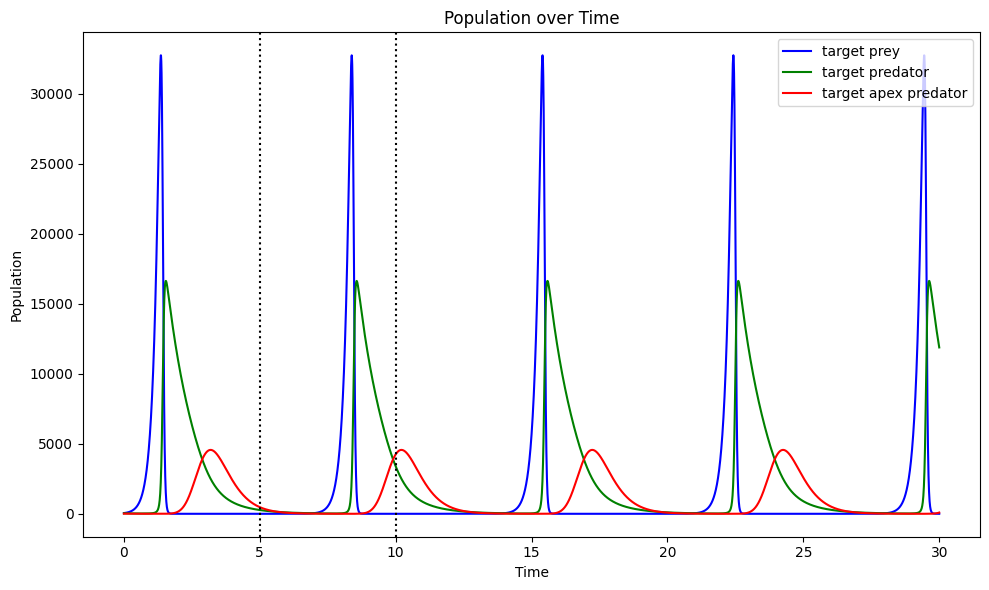

In [5]:
plot_system(y_target_response)

### Get a simple fitted model for comparison with supermodelling

Sample a few data points and their "correct" responses

In [6]:
sampling_idx = np.arange(0, 3001, 100)[20:31]
t_samples = t_axis[sampling_idx]
y_samples = np.ravel(np.transpose(y_target_response[sampling_idx]))

Fit the parameters

In [7]:
from scipy.optimize import curve_fit

reference_starting_params = np.array(
    [5.1, 0.0021, 0.0007, 1.1, 0.00011, 0.000801, 2.01, 50.0, 34.95, 10.1]
)

predicted_ref_model_params, _ = curve_fit(
    lotka_volterra_sampler, t_samples, y_samples, p0=reference_starting_params
)

y_pred_ref_responses = odeint(
    lotka_volterra,
    predicted_ref_model_params[-3:],
    axis_for_plotting,
    args=tuple(predicted_ref_model_params[:-3]),
)

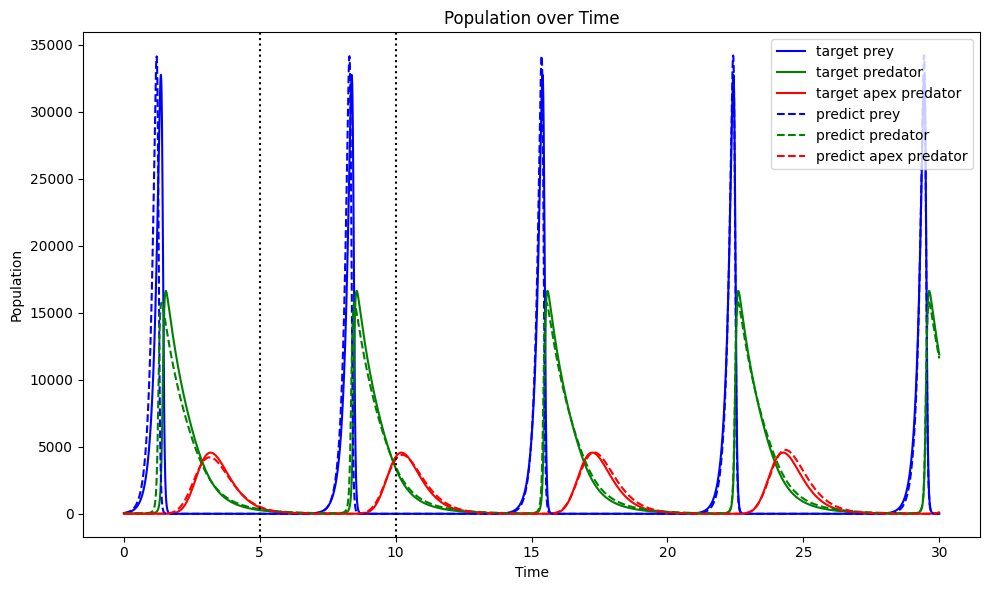

In [8]:
plot_system(y_target_response, y_pred_ref_responses)

In [9]:
import pandas as pd

param_names = [
    "alpha",
    "beta",
    "delta",
    "gamma",
    "epsilon",
    "eta",
    "zeta",
    "x0",
    "y0",
    "z0",
]

df_params = pd.DataFrame(index=param_names)
df_params["starting"] = reference_starting_params
df_params["predicted"] = predicted_ref_model_params
df_params["target"] = correct_params
df_params

,starting,predicted,target
alpha,5.100000,5.674705,5.0000
beta,0.002100,0.002195,0.0020
delta,0.000700,0.000657,0.0007
gamma,1.100000,0.897529,1.0000
epsilon,0.000110,0.000086,0.0001
eta,0.000801,0.000744,0.0008
zeta,2.010000,1.915950,2.0000
x0,50.000000,54.565673,50.0000
y0,34.950000,51.976112,35.0000
z0,10.100000,11.449812,10.0000


We get a roughly good reference prediction without supermodelling

### Initialize 3 models with different starting conditions

C:\Users\piotr\AppData\Local\Temp\ipykernel_30820\1296116328.py:31: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  ySoln = odeint(


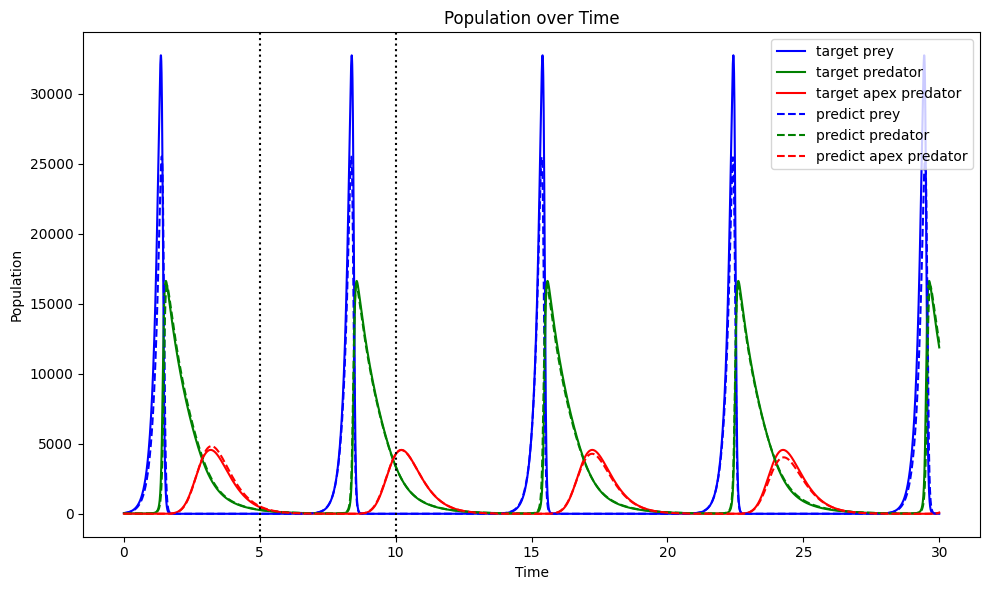

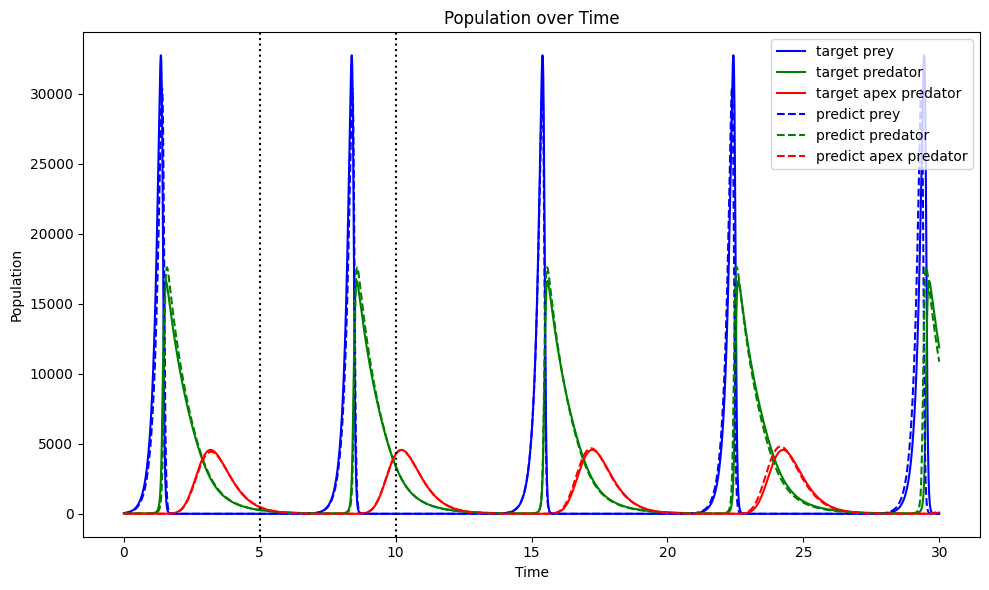

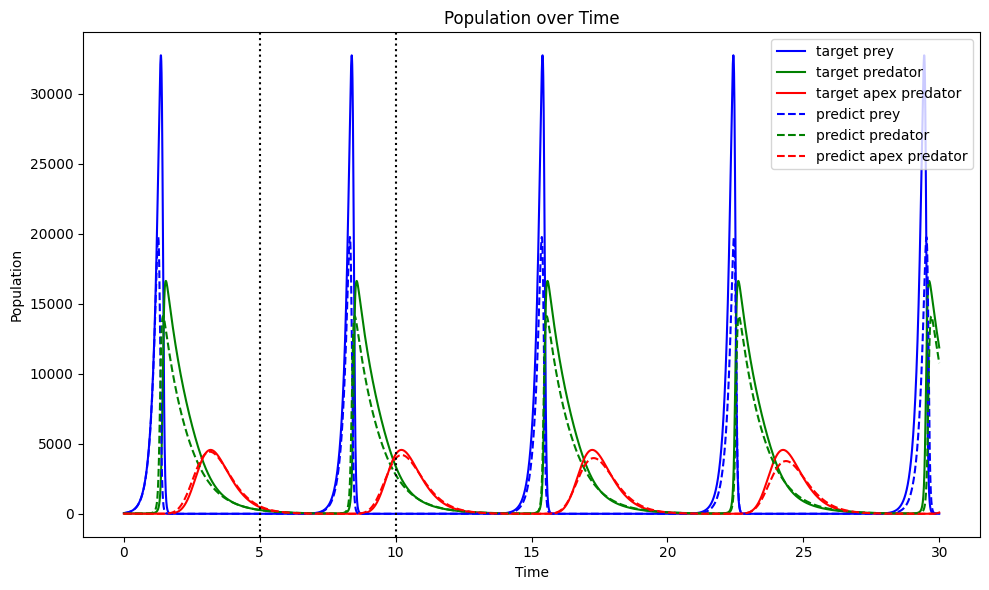

In [10]:
from scipy.optimize import curve_fit

supermodelling_starting_points = np.array(
    [
        [5.0, 0.00199, 0.0008, 0.99, 0.00009, 0.0008001, 2.2, 43.0, 20.0, 13.0],
        [4.91, 0.0021, 0.00065, 1.1, 0.00017, 0.0007, 1.998, 58.0, 39.0, 16.0],
        [4.9, 0.0022, 0.00069, 1.13, 0.0002, 0.00079, 1.999, 49.0, 36.0, 11.0],
    ]
)

supermodelling_pred_params = []
supermodelling_responses = []
for sp in supermodelling_starting_points:
    predicted_params, _ = curve_fit(lotka_volterra_sampler, t_samples, y_samples, p0=sp)
    supermodelling_pred_params.append(predicted_params)

    y_pred_ref_responses = odeint(
        lotka_volterra,
        predicted_params[-3:],
        axis_for_plotting,
        args=tuple(predicted_params[:-3]),
    )
    supermodelling_responses.append(y_pred_ref_responses)

    plot_system(y_target_response, y_pred_ref_responses)

In [11]:
param_names = [
    "alpha",
    "beta",
    "delta",
    "gamma",
    "epsilon",
    "eta",
    "zeta",
    "x0",
    "y0",
    "z0",
]

df_params = pd.DataFrame(index=param_names)
df_params["reference_model"] = predicted_ref_model_params
df_params[["super1", "super2", "super3"]] = np.stack(supermodelling_pred_params).T
df_params["target"] = correct_params
df_params

,reference_model,super1,super2,super3,target
alpha,5.674705,4.771604,4.861546,5.032905,5.0000
beta,0.002195,0.001906,0.001912,0.002346,0.0020
delta,0.000657,0.000838,0.000783,0.001160,0.0007
gamma,0.897529,0.988867,1.076545,1.063908,1.0000
epsilon,0.000086,0.000096,0.000081,0.000029,0.0001
eta,0.000744,0.000793,0.000775,0.000901,0.0008
zeta,1.915950,1.996170,1.965078,1.942380,2.0000
x0,54.565673,46.276469,44.123938,47.789631,50.0000
y0,51.976112,39.328476,30.222804,30.270713,35.0000
z0,11.449812,13.634495,10.995283,13.076037,10.0000


In [12]:
initial_params = np.stack(supermodelling_pred_params).T.flatten()

### Build a supermodel

In [22]:
def super_lotka_volterra(vars, t, *params):
    (
        alpha1,
        alpha2,
        alpha3,
        beta1,
        beta2,
        beta3,
        delta1,
        delta2,
        delta3,
        gamma1,
        gamma2,
        gamma3,
        epsilon1,
        epsilon2,
        epsilon3,
        eta1,
        eta2,
        eta3,
        zeta1,
        zeta2,
        zeta3,
    ) = initial_params[:-9]

    Cy12, Cy13, Cy21, Cy23, Cy31, Cy32 = params

    x1, x2, x3, y1, y2, y3, z1, z2, z3 = vars

    dxdt1 = alpha1 * x1 - beta1 * x1 * y1
    dydt1 = (
        delta1 * x1 * y1
        - gamma1 * y1
        - epsilon1 * y1 * z1
        + Cy12 * (y2 - y1)
        + Cy13 * (y3 - y1)
    )
    dzdt1 = eta1 * y1 * z1 - zeta1 * z1

    dxdt2 = alpha1 * x2 - beta1 * x2 * y2
    dydt2 = (
        delta1 * x2 * y2
        - gamma2 * y2
        - epsilon1 * y2 * z2
        + Cy21 * (y1 - y2)
        + Cy23 * (y3 - y2)
    )
    dzdt2 = eta2 * y2 * z2 - zeta2 * z2

    dxdt3 = alpha3 * x3 - beta3 * x3 * y3
    dydt3 = (
        delta3 * x3 * y3
        - gamma3 * y3
        - epsilon3 * y3 * z3
        + Cy31 * (y1 - y3)
        + Cy32 * (y2 - y3)
    )
    dzdt3 = eta3 * y3 * z3 - zeta3 * z3

    return [dxdt1, dxdt2, dxdt3, dydt1, dydt2, dydt3, dzdt1, dzdt2, dzdt3]


# model to return values of the system at samples_t points in time for given params
def super_lotka_volterra_sampler(
    samples_t,
    *params,
):

    initial_values = initial_params[-9:]

    response_y = np.zeros((len(samples_t), len(initial_values)))

    for i in np.arange(0, len(samples_t)):
        if samples_t[i] == 0.0:  # should include a decimal
            response_y[i, :] = np.array(initial_values)
        else:
            t_span = np.linspace(0.0, samples_t[i], 100)
            ySoln = odeint(
                super_lotka_volterra, initial_values, t_span, args=tuple(params)
            )
            response_y[i, :] = ySoln[-1, :]

    response = np.hstack(
        [
            response_y[:, 0:3].mean(axis=-1, keepdims=True),
            response_y[:, 3:6].mean(axis=-1, keepdims=True),
            response_y[:, 6:9].mean(axis=-1, keepdims=True),
        ]
    )

    return np.ravel(np.transpose(response))

### Fit the supermodel

In [23]:
super_starting_params = np.array([1, 1, 1, 1, 1, 1])

supermodel_params, _ = curve_fit(
    super_lotka_volterra_sampler, t_samples, y_samples, p0=super_starting_params
)

super_y = odeint(
    lotka_volterra,
    predicted_ref_model_params[-3:],
    axis_for_plotting,
    args=tuple(predicted_ref_model_params[:-3]),
)

C:\Users\piotr\AppData\Local\Temp\ipykernel_30820\3891277474.py:44: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  ySoln = odeint(


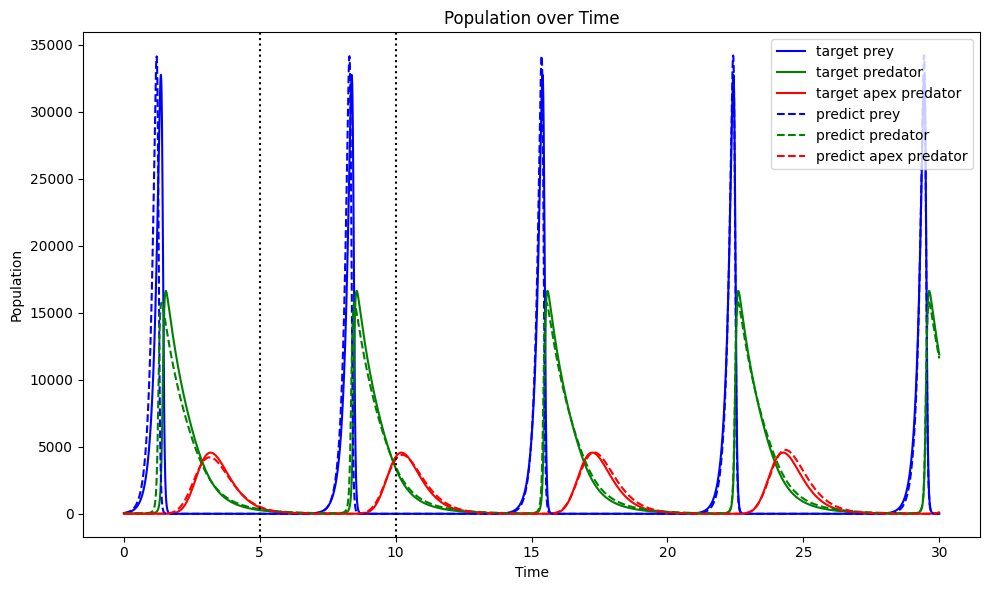

In [24]:
plot_system(y_target_response, super_y)

In [25]:
supermodel_params

array([-230.38415518,   12.57766108,  -69.57709151,   -1.15209199,
       -121.03712177,  113.79879373])

In [26]:
np.sqrt(np.square(y_target_response - y_pred_ref_responses).mean())

1934.1872877494357

In [27]:
np.sqrt(np.square(y_target_response - super_y).mean())

1707.2088369745156

We get lower RMS error for supermodelling! Comparing with 3 separate models, the predictions outside the fitting range are also better for supermodelling.